## ML-Model: Random Forest

# import libraries

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

#sklearn

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, make_scorer, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# import custom functions

from custom_functions import get_data_summary, our_metrics, eval_metrics, get_f15, get_f2, get_f3

import warnings
warnings.filterwarnings('ignore')
RSEED = 42

In [2]:
#codeline for non-tree models

# X_train_minmax = pd.read_csv('data/X_train_minmax.csv', delimiter=',')
# X_test_minmax = pd.read_csv('data/X_test_minmax.csv', delimiter=',')
# X_train_std = pd.read_csv('data/X_train_std.csv', delimiter=',')
# X_test_std = pd.read_csv('data/X_test_std.csv', delimiter=',')
# y_train = pd.read_csv('data/y_train.csv', delimiter=',')
# y_test = pd.read_csv('data/y_test.csv', delimiter=',')

# Import train-train-split for trees

In [3]:
# Import train-train-split for trees
X_train_tree_small = pd.read_csv('data/X_train_tree_small.csv', delimiter=',')
X_train_tree_large = pd.read_csv('data/X_train_tree_large.csv', delimiter=',')
y_train_tree_small = pd.read_csv('data/y_train_tree_small.csv', delimiter=',')
y_train_tree_large = pd.read_csv('data/y_train_tree_large.csv', delimiter=',')

In [4]:
#reshape y into 2D-array

y_train_tree_small = np.ravel(y_train_tree_small)
y_train_tree_large = np.ravel(y_train_tree_large)

# Import entire data set: test and train data, target

In [5]:
# X_train_tree = pd.read_csv('data/X_train_tree.csv', delimiter=',')
# X_test_tree = pd.read_csv('data/X_test_tree.csv', delimiter=',')
# y_train_tree = pd.read_csv('data/y_train_tree.csv', delimiter=',')
# y_test_tree = pd.read_csv('data/y_test_tree.csv', delimiter=',')

In [6]:
#reshape y into array

# y_test_tree = np.ravel(y_test_tree)
# y_train_tree = np.ravel(y_train_tree)

# Instantiating and training model with default hyperparams

In [7]:
# Create the model with 100 trees
random_forest_default = RandomForestClassifier(n_estimators=500, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1, max_depth=60, min_samples_split=10)

# Fit on small subset of training data
random_forest_default.fit(X_train_tree_small, y_train_tree_small)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.2min finished


RandomForestClassifier(max_depth=60, min_samples_split=10, n_estimators=500,
                       n_jobs=-1, random_state=42, verbose=1)

In [8]:
# number of nodes and depths of trees in the forest:

n_nodes = []
max_depths = []

for ind_tree in random_forest_default.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 117699
Average maximum depth 58


# Default hyperpaprams model performance

In [9]:
# predicting target and prediction probabilities with small data subset:

rf_y_pred_train_small = random_forest_default.predict(X_train_tree_small)
rf_y_probs_train_small = random_forest_default.predict_proba(X_train_tree_small)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   39.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   38.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  1.7min finished


Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.9372
_____________________
F1-score: 0.3426
_____________________
Fbeta_score with beta=1.5: 0.274
_____________________
Fbeta_score with beta=2: 0.2463
_____________________
Fbeta_score with beta=3: 0.2252
_____________________
Recall 0.2075
_____________________
Specificity 0.9997


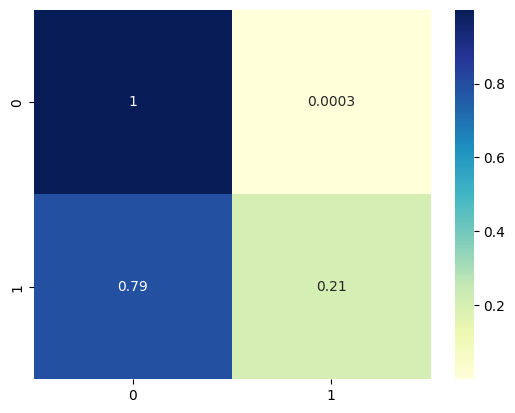

In [10]:
# accuracy matrix: predicted target and true target (small subset of training data)

our_metrics(y_train_tree_small, rf_y_pred_train_small)

In [11]:
# roc-auc-score of train (small subsample)
print(f'Train ROC AUC Score: {roc_auc_score(y_train_tree_small, rf_y_probs_train_small)}')
#print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Train ROC AUC Score: 0.9942110090670602


In [12]:
# predicting target and prediction probabilities with large data subset:

rf_y_pred_train_large = random_forest_default.predict(X_train_tree_large)
rf_y_probs_train_large = random_forest_default.predict_proba(X_train_tree_large)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   19.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 13.3min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 15.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  6.2min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 33.2min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 33.7min finished


Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.9273
_____________________
F1-score: 0.1752
_____________________
Fbeta_score with beta=1.5: 0.1344
_____________________
Fbeta_score with beta=2: 0.1189
_____________________
Fbeta_score with beta=3: 0.1074
_____________________
Recall 0.0979
_____________________
Specificity 0.9983


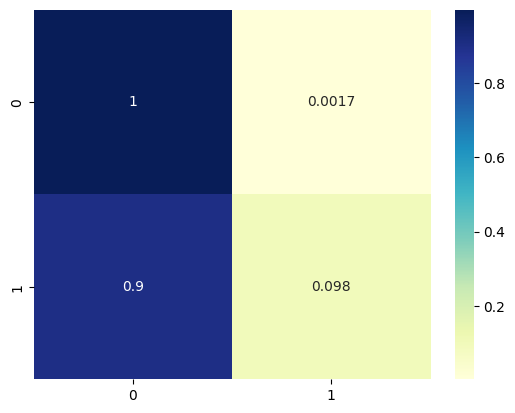

In [13]:
# accuracy matrix: predicted target and true target (large subset of training data)

our_metrics(y_train_tree_large, rf_y_pred_train_large)

In [14]:
# roc-auc-score of test (large subsample)
print(f'Train ROC AUC Score: {roc_auc_score(y_train_tree_large, rf_y_probs_train_large)}')

Train ROC AUC Score: 0.7733384519320049


# RandomizedSearch CV for best Fbeta-Score

In [15]:
# making own scorer to use in random search cross validation
# set beta = 1.5, 2, 3

f15_scorer = make_scorer(fbeta_score, beta=1.5)
f2_scorer = make_scorer(fbeta_score, beta=2)
f3_scorer = make_scorer(fbeta_score, beta=3)

In [16]:
# number of nodes and depths of trees in the forest:

n_nodes = []
max_depths = []

for ind_tree in random_forest_default.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 117699
Average maximum depth 58


In [17]:
# hypeparameters set in default model

random_forest_default.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 60,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 1,
 'warm_start': False}

In [18]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100],
    'max_depth': [None] + list(np.linspace(30, 60, 6).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.1)),
    'min_samples_split': np.linspace(10, 200, 10).astype(int),
    'min_samples_leaf': np.linspace(5, 50, 10).astype(int),
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
random_forest_rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = f15_scorer, cv = 3, 
                        n_iter = 10, verbose = 5, random_state=RSEED)

# cv = cross validation

# Fit 
random_forest_rs.fit(X_train_tree_small, y_train_tree_small)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/annastein/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/annastein/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/annastein/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been depr

[CV 3/3] END bootstrap=True, max_depth=36, max_features=auto, min_samples_leaf=35, min_samples_split=10, n_estimators=100;, score=0.001 total time=148.4min
[CV 1/3] END bootstrap=True, max_depth=36, max_features=auto, min_samples_leaf=35, min_samples_split=10, n_estimators=100;, score=0.003 total time=148.4min
[CV 1/3] END bootstrap=False, max_depth=54, max_features=0.0, min_samples_leaf=50, min_samples_split=31, n_estimators=100;, score=nan total time=   1.2s
[CV 2/3] END bootstrap=False, max_depth=54, max_features=0.0, min_samples_leaf=50, min_samples_split=31, n_estimators=100;, score=nan total time=   1.1s


/Users/annastein/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/3] END bootstrap=True, max_depth=36, max_features=auto, min_samples_leaf=35, min_samples_split=10, n_estimators=100;, score=0.001 total time=148.5min
[CV 3/3] END bootstrap=False, max_depth=54, max_features=0.0, min_samples_leaf=50, min_samples_split=31, n_estimators=100;, score=nan total time=   0.7s
[CV 1/3] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=100;, score=0.003 total time=150.0min
[CV 3/3] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=100;, score=0.003 total time=150.0min
[CV 2/3] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=50, min_samples_split=10, n_estimators=100;, score=0.003 total time=150.1min
[CV 2/3] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=15, min_samples_split=136, n_estimators=100;, score=0.009 total time=151.1min
[CV 1/3] END bootstrap=False, max_depth=60, max_features=auto,

/Users/annastein/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/3] END bootstrap=False, max_depth=36, max_features=sqrt, min_samples_leaf=40, min_samples_split=52, n_estimators=100;, score=0.003 total time=43.1min


/Users/annastein/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/3] END bootstrap=False, max_depth=36, max_features=sqrt, min_samples_leaf=40, min_samples_split=52, n_estimators=100;, score=0.004 total time=43.1min


/Users/annastein/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/3] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=35, min_samples_split=136, n_estimators=100;, score=0.002 total time=40.6min
[CV 3/3] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=15, min_samples_split=136, n_estimators=100;, score=0.009 total time=43.6min
[CV 3/3] END bootstrap=False, max_depth=36, max_features=sqrt, min_samples_leaf=40, min_samples_split=52, n_estimators=100;, score=0.004 total time=52.4min
[CV 3/3] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=35, min_samples_split=136, n_estimators=100;, score=0.001 total time=19.6min
[CV 2/3] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=35, min_samples_split=136, n_estimators=100;, score=0.002 total time=19.7min


/Users/annastein/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/annastein/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/3] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=20, min_samples_split=94, n_estimators=100;, score=0.007 total time=54.3min


/Users/annastein/neuefische/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/3] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=20, min_samples_split=94, n_estimators=100;, score=0.008 total time=54.4min
[CV 1/3] END bootstrap=False, max_depth=60, max_features=0.0, min_samples_leaf=40, min_samples_split=178, n_estimators=100;, score=nan total time=   0.6s
[CV 2/3] END bootstrap=False, max_depth=60, max_features=0.0, min_samples_leaf=40, min_samples_split=178, n_estimators=100;, score=nan total time=   0.6s
[CV 3/3] END bootstrap=False, max_depth=60, max_features=0.0, min_samples_leaf=40, min_samples_split=178, n_estimators=100;, score=nan total time=   0.5s
[CV 3/3] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=20, min_samples_split=94, n_estimators=100;, score=0.007 total time=59.8min
[CV 1/3] END bootstrap=False, max_depth=48, max_features=auto, min_samples_leaf=15, min_samples_split=136, n_estimators=100;, score=0.008 total time=102.3min
[CV 2/3] END bootstrap=False, max_depth=48, max_features=auto, min_s

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 30, 36, 42, 48, 54,
                                                      60],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.0],
                                        'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
                                        'min_samples_split': array([ 10,  31,  52,  73,  94, 115, 136, 157, 178, 200]),
                                        'n_estimators': [100]},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=1.5),
                   verbose=5)

In [23]:
# # Best score
print('Best score:', round(random_forest_rs.best_score_,2))

# # Best parameters
print('Best parameters:', random_forest_rs.best_params_)

Best score: 0.08
Best parameters: {'n_estimators': 100, 'min_samples_split': 52, 'min_samples_leaf': 50, 'max_features': None, 'max_depth': None, 'bootstrap': False}


In [24]:
# # Assigning the fitted SGDClassifier model with best parameter combination to a new variable sgd_best
random_forest_best_model = random_forest_rs.best_estimator_

In [25]:
# predicting target and prediction probabilities with large data subset using the best model found in random grid search:

rs_y_pred_train_large = random_forest_best_model.predict(X_train_tree_large)
rs_y_probs_train_large = random_forest_best_model.predict_proba(X_train_tree_large)[:, 1]

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.9273
_____________________
F1-score: 0.1752
_____________________
Fbeta_score with beta=1.5: 0.1344
_____________________
Fbeta_score with beta=2: 0.1189
_____________________
Fbeta_score with beta=3: 0.1074
_____________________
Recall 0.0979
_____________________
Specificity 0.9983


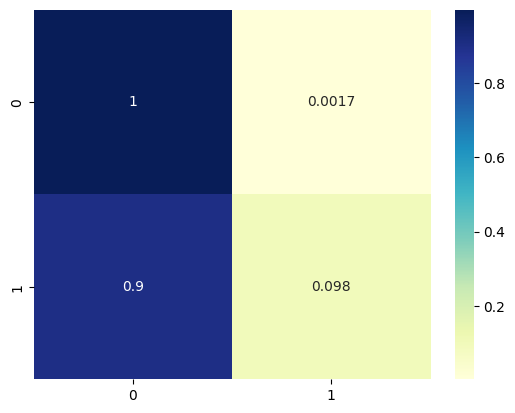

In [26]:
# metrics of best model found in random grid search

our_metrics(y_train_tree_large, rf_y_pred_train_large)